In [16]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'ROCR',
    'stringr',
    'caret',
    'caTools',
    'ggpubr'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

source("my_R_functions/utility_functions.R")
source("my_R_functions/stat_functions.R")
source("my_R_functions/plot_functions.R")
source("/ssd/mrichard/github/BDDS/trenadb/src/utils.R")
source("/ssd/mrichard/github/BDDS/footprints/testdb/src/dbFunctions.R")

[1] "ggpubr"        "magrittr"      "bindrcpp"      "RUnit"        
 [5] "GenomicRanges" "GenomeInfoDb"  "IRanges"       "S4Vectors"    
 [9] "BiocGenerics"  "parallel"      "stats4"        "RPostgreSQL"  
[13] "DBI"           "caTools"       "caret"         "lattice"      
[17] "stringr"       "ROCR"          "gplots"        "pROC"         
[21] "tidyr"         "dplyr"         "glmnet"        "foreach"      
[25] "Matrix"        "xgboost"       "ggplot2"       "RColorBrewer" 
[29] "stats"         "graphics"      "grDevices"     "utils"        
[33] "datasets"      "methods"       "base"

# Data Preparation

We're going to load a number of things here:

1. Mappings between Motif and transcription factor (TF) class
2. Mappings between Motif and TF
3. Our annotated data set of ChipSeq positive/negative hits

In [3]:
load("Rdata_files/motif_class_pairs.Rdata")
load("Rdata_files/Tfmotifmap.Rdata")

In [5]:
load("/ssd/mrichard/data/all.TF.df.fimo.hint.well.seed20.annotated.9.Rdata")

Let's quickly take a look at what we're dealing with here, just to get an idea of scope:

In [6]:
str(all.TF.df.fimo.hint.well.annotated)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	24720556 obs. of  39 variables:
 $ motifname                               : chr  "Mmusculus-jaspar2016-Nfe2l2-MA0150.2" "Mmusculus-jaspar2016-Bach1::Mafk-MA0591.1" "Hsapiens-jaspar2016-JUND(var.2)-MA0492.1" "Hsapiens-jaspar2016-ATF7-MA0834.1" ...
 $ chrom                                   : chr  "1" "1" "1" "1" ...
 $ start                                   : int  1677938 1677939 1828558 2255916 2255789 2255823 2255891 2255917 2255949 2255983 ...
 $ endpos                                  : int  1677952 1677953 1828572 2255929 2255803 2255837 2255905 2255931 2255963 2255997 ...
 $ strand                                  : chr  "+" "+" "-" "-" ...
 $ motifscore                              : num  13.35 11.71 9.73 8.03 13.72 ...
 $ pval                                    : num  1.13e-05 1.37e-05 9.18e-05 6.68e-05 1.48e-05 1.48e-05 1.48e-05 8.28e-06 1.48e-05 1.48e-05 ...
 $ sequence                                : chr  "CACTGTGACTCCGCA" "ACTGTGA

In order to simplify things, we're going to filter out just the subset where we either THINK we have a hit, where we DO have a hit, or both. 

In [7]:
colnames(all.TF.df.fimo.hint.well.annotated) <- make.names(colnames(all.TF.df.fimo.hint.well.annotated), unique=TRUE)

all.TF.df.fimo.hint.well.annotated %>%
    filter(h_frac > 0 | w_frac > 0 | cs_hit > 0) ->
    df_only_footprint_hits

We'll also remove all the information about class, as that won't come into it when we're talking about an individual TF. 

In [8]:
df_only_footprint_hits %>%
    select(chrom,
           cs_hit,
           motifname,
           motifscore,
           h_frac,
           h_max_score,
           w_frac,
           w_min_score,
           gc_content,
           asinh_tss_dist) ->
    df_cols_selected

head(df_cols_selected)

chrom,cs_hit,motifname,motifscore,h_frac,h_max_score,w_frac,w_min_score,gc_content,asinh_tss_dist
1,1,Mmusculus-jaspar2016-Nfe2l2-MA0150.2,13.34830,0.48,2096,0.13333333,-33.02390,0.6119403,10.29384
1,1,Mmusculus-jaspar2016-Bach1::Mafk-MA0591.1,11.70790,0.46,2096,0.13333333,-33.02390,0.6169154,10.29377
1,1,Hsapiens-jaspar2016-JUND(var.2)-MA0492.1,9.73034,0.22,207,0.06666667,-5.38997,0.3283582,11.47418
1,1,Hsapiens-jaspar2016-ATF7-MA0834.1,8.03371,0.14,465,0.30000000,-33.99660,0.5174129,10.90485
1,1,Hsapiens-jaspar2016-JUND(var.2)-MA0492.1,13.71910,0.08,257,0.16666667,-33.61900,0.4875622,10.90018
1,1,Hsapiens-jaspar2016-JUND(var.2)-MA0492.1,13.71910,0.22,277,0.23333333,-32.24370,0.5024876,10.90143


This constitutes our starting set of information. Now we'll split into training/testing/validation sets. We don't expect chromosome to have an effect on the results, so this gives us an easy way to split:

In [9]:
df_cols_selected %>%
    filter(chrom %in% c("2","4")) %>%
    select(-chrom) ->
    val_df

df_cols_selected %>%
    filter(chrom %in% c("1","3","5")) %>%
    select(-chrom) ->
    test_df

df_cols_selected %>%
    filter(!(chrom %in% c("1","2","3","4","5"))) %>%
    select(-chrom) ->
    train_df

remove(all.TF.df.fimo.hint.well.annotated, df_only_footprint_hits)

dim(train_df); dim(test_df);

# Transcription Factor Selection

Our goal is to look at how motif choice affects prediction accuracy within one TF; to accomplish this, it makes sense to find a transcription factor with a large number of motifs. We'll determine this using our mapping, grouping our motifs together by TF and then counting to figure out which TF has the highest number. We'll also plot the motif/TF relationship just to illustrate what it looks like.

First, let's see what the mapping looks like:

In [11]:
head(TFs.to.motifs)

$ATF2
[1] "Mmusculus-jaspar2016-Creb5-MA0840.1"      
[2] "Mmusculus-jaspar2016-Bach1::Mafk-MA0591.1"
[3] "Hsapiens-jaspar2016-JUND-MA0491.1"        
[4] "Mmusculus-jaspar2016-Nfe2l2-MA0150.2"     
[5] "Ggallus-jaspar2016-MAFG::NFE2L1-MA0089.1" 
[6] "Hsapiens-jaspar2016-ATF7-MA0834.1"        
[7] "Hsapiens-jaspar2016-JUND(var.2)-MA0492.1" 
[8] "Hsapiens-jaspar2016-JUNB-MA0490.1"        

$ATF3
[1] "Hsapiens-jaspar2016-JDP2-MA0655.1"       
[2] "Mmusculus-jaspar2016-Atf3-MA0605.1"      
[3] "Hsapiens-jaspar2016-JDP2(var.2)-MA0656.1"

$BATF
[1] "Hsapiens-jaspar2016-BATF::JUN-MA0462.1" 
[2] "Hsapiens-jaspar2016-JUN(var.2)-MA0489.1"
[3] "Hsapiens-jaspar2016-BATF3-MA0835.1"     

$BCL11A
[1] "Hsapiens-jaspar2016-RUNX2-MA0511.1"  "Mmusculus-jaspar2016-RUNX1-MA0002.2"

$BHLHE40
[1] "Mmusculus-jaspar2016-Myc-MA0147.1"   
[2] "Mmusculus-jaspar2016-Npas2-MA0626.1" 
[3] "Hsapiens-jaspar2016-MAX-MA0058.3"    
[4] "Hsapiens-jaspar2016-MNT-MA0825.1"    
[5] "Hsapiens-jaspar2016-BHLHE40-MA0464.2"

$CEBPB
[1] "Hsapiens-jaspar2016-CEBPA-MA0102.3" "Hsapiens-jaspar2016-CEBPB-MA0466.2"
[3] "Hsapiens-jaspar2016-CEBPB-MA0466.1"

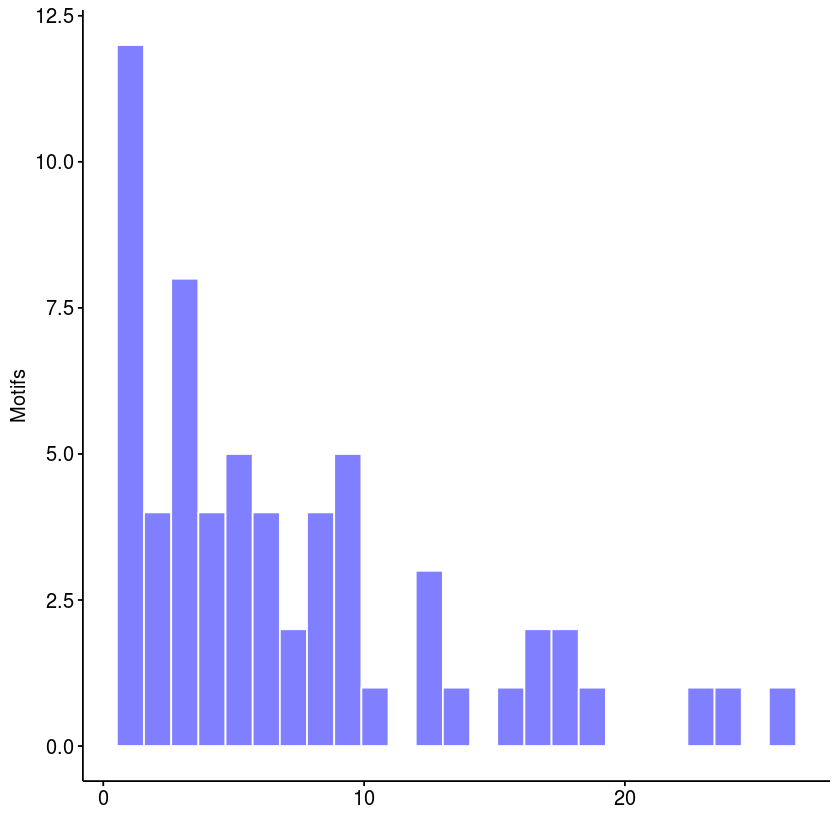

In [22]:
sapply(TFs.to.motifs, length) %>% gghistogram(fill = "blue", 
                                              color = "white",
                                              xlab = "",
                                              ylab = "Motifs",
                                              bins = 25
                                             )

As we can see, the vast majority of TFs have fewer than 10 motifs; however, a few have over 20. Let us grab the top TF, which should give us our best candidate

In [29]:
TF.sums <- sapply(TFs.to.motifs, length) 
top.TF <- names(TF.sums)[which(TF.sums == max(TF.sums))]
TF.sums[top.TF]

ELF1 
  26

# Model Training

We'll narrow our data frame down to the motifs that correspond to this TF, then we'll train a model on each of these motifs individually


In [51]:
only.my.motifs <- TFs.to.motifs[[top.TF]]
train_df %>% filter(motifname %in% only.my.motifs) -> train_df
test_df %>% filter(motifname %in% only.my.motifs) -> test_df

dim(train_df); dim(test_df)

[1] 509916      9

[1] 134786      9

In [52]:
all_stats_df <- data.frame()

for (motif in only.my.motifs) {
    
    # filter down to only the relevant motif
    train_df %>%
        filter(motifname == motif) ->
        this_motif_train_df
    test_df %>%
        filter(motifname == motif) ->
        this_motif_test_df
    
    # make training and testing data sets
    X_train_this_motif <- as.matrix(select(this_motif_train_df,-one_of("cs_hit", "motifname")))
    y_train_this_motif <- this_motif_train_df$cs_hit
    X_test_this_motif <- as.matrix(select(this_motif_test_df,-one_of("cs_hit", "motifname")))
    y_test_this_motif <- this_motif_test_df$cs_hit
    
    # set parameters for gbdt
    param <- list("objective" = "binary:logistic",
          "max.depth" = 5,
          "eta" = 0.01,
          "eval.metric" = "auc"
          )
    
    # train gbdt
    gbdt_motif <- xgboost(
        params = param,
        data = X_train_this_motif,
        label = y_train_this_motif,
        nround = 100,
        verbose = FALSE,
        missing = NA
    )
    
    # Name it with the short motif name
    short.motif <- gsub(".+(MA\\d{4}\\.\\d).*","\\1",motif)
    gbdt_motif$Model.Name <- short.motif
    
    
    # gather statistics for model on this TF
    this_motif_pred_df <- make.pred.df.from.model(gbdt_motif, X_test_this_motif, y_test_this_motif)
    colnames(this_motif_pred_df)[1] <- "ChIPseq.bound"
    this_motif_stat_df <- make.stats.df.from.preds(this_motif_pred_df)
    this_motif_stat_df$Train.Samples <- length(y_train_this_motif)
    this_motif_stat_df$Test.Samples <- length(y_test_this_motif)
    
    # save stats
    all_stats_df <- rbind(all_stats_df, this_motif_stat_df)

}

In [53]:
str(all_stats_df)

'data.frame':	2626 obs. of  10 variables:
 $ threshold    : num  0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 ...
 $ sensitivity  : num  1 1 1 1 1 1 1 1 1 1 ...
 $ specificity  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ppv          : num  0.484 0.484 0.484 0.484 0.484 ...
 $ npv          : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ accuracy     : num  0.484 0.484 0.484 0.484 0.484 ...
 $ MattCC       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Model.Name   : chr  "MA0762.1" "MA0762.1" "MA0762.1" "MA0762.1" ...
 $ Train.Samples: int  9905 9905 9905 9905 9905 9905 9905 9905 9905 9905 ...
 $ Test.Samples : int  2759 2759 2759 2759 2759 2759 2759 2759 2759 2759 ...


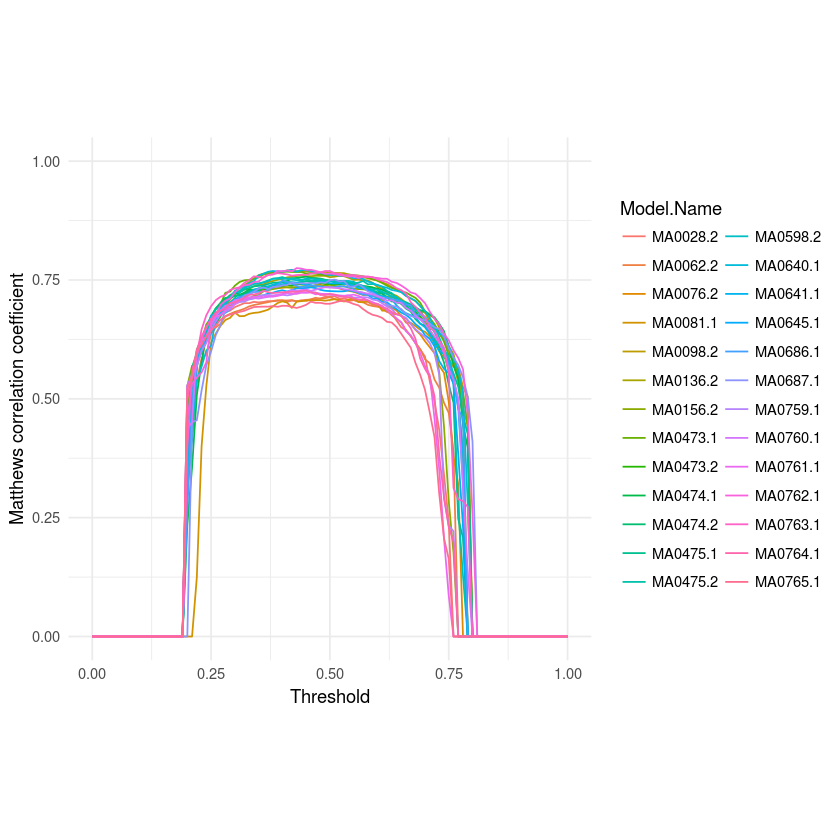

In [54]:
plot.mattcc.curve(all_stats_df) + theme_minimal()

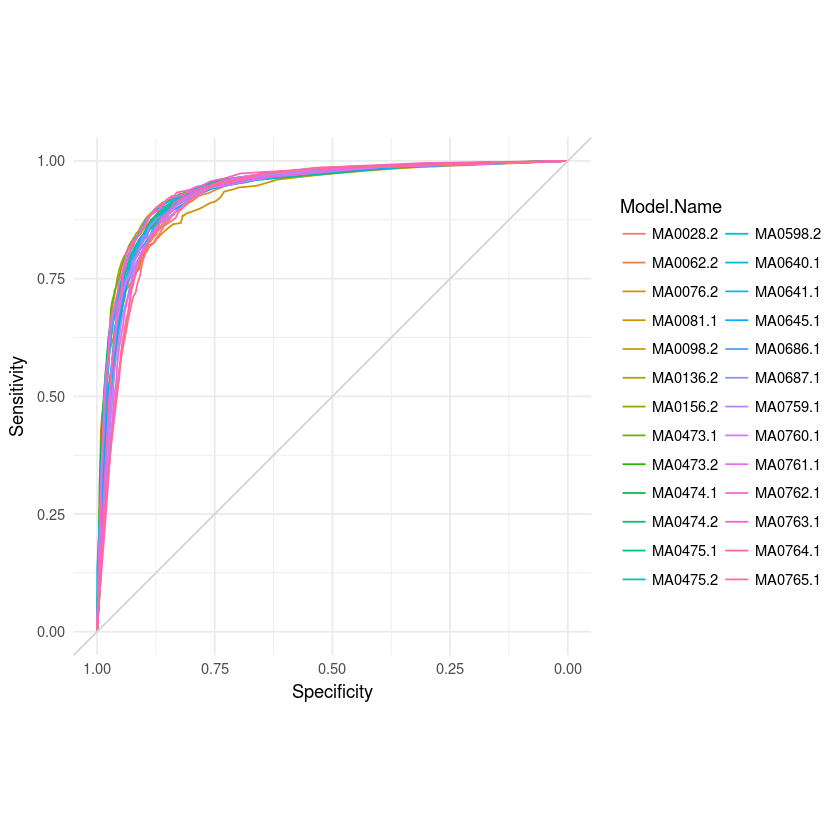

In [55]:
plot.roc.curve(all_stats_df) + theme_minimal()

Warning message:
“Removed 578 rows containing missing values (geom_path).”

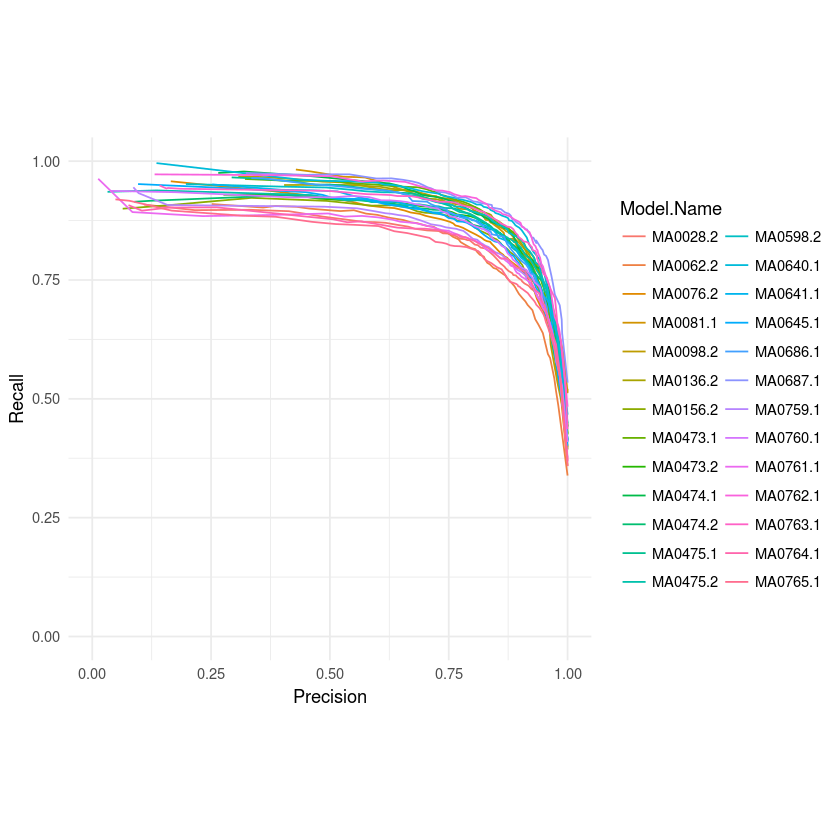

In [56]:
plot.precrecall.curve(all_stats_df) + theme_minimal()

`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over a selection of variables, use `summarise_at()`


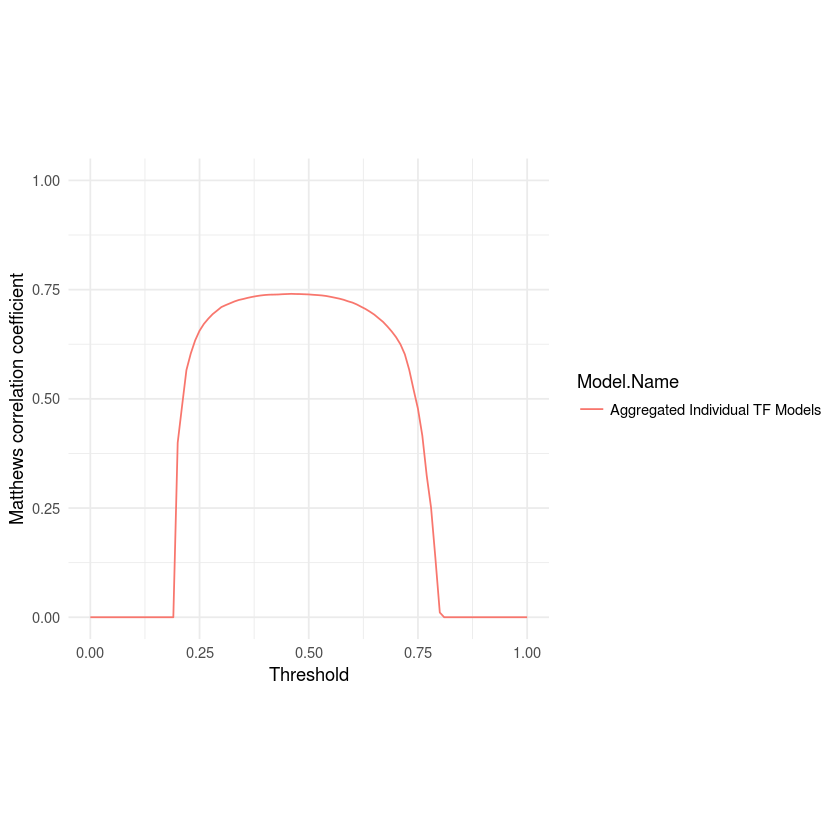

In [57]:
all_stats_df %>%
    select(-Model.Name) %>%
    group_by(threshold) %>%
    summarise_each(funs(weighted.mean(., Test.Samples)), -one_of("Test.Samples","Train.Samples")) %>%
    mutate(Model.Name="Aggregated Individual TF Models") %>%
    plot.mattcc.curve

In [58]:
all_stats_motif_df <- data.frame()

motifs <- unique(train_df$motifname) %>% intersect(unique(test_df$motifname))
for (motif in motifs) {
    
    # filter down to only relevant motifs
    train_df %>%
        filter(motifname == motif) ->
        this_motif_train_df
    test_df %>%
        filter(motifname == motif) ->
        this_motif_test_df
    
    # make training and testing data sets
    X_train_this_motif <- as.matrix(select(this_motif_train_df,-one_of("cs_hit", "motifname")))
    y_train_this_motif <- this_motif_train_df$cs_hit
    X_test_this_motif <- as.matrix(select(this_motif_test_df,-one_of("cs_hit", "motifname")))
    y_test_this_motif <- this_motif_test_df$cs_hit
    
    # set parameters for gbdt
    param <- list("objective" = "binary:logistic",
          "max.depth" = 5,
          "eta" = 0.01,
          "eval.metric" = "auc"
          )
    
    # train gbdt
    gbdt_motif <- xgboost(
        params = param,
        data = X_train_this_motif,
        label = y_train_this_motif,
        nround = 100,
        verbose = FALSE,
        missing = NA
    )
    gbdt_motif$Model.Name <- motif
    
    
    # gather statistics for model on this motif
    this_motif_pred_df <- make.pred.df.from.model(gbdt_motif, X_test_this_motif, y_test_this_motif)
    colnames(this_motif_pred_df)[1] <- "ChIPseq.bound"
    this_motif_stat_df <- make.stats.df.from.preds(this_motif_pred_df)
    this_motif_stat_df$Train.Samples <- length(y_train_this_motif)
    this_motif_stat_df$Test.Samples <- length(y_test_this_motif)
    
    # save stats
    all_stats_motif_df <- rbind(all_stats_motif_df, this_motif_stat_df)

}

In [59]:
load(file="per_TF_output/all_together_tree_stats.Rdata")
medium_stat_df$Model.Name <- "All together Trees with Classes"

In [60]:
all_stats_motif_df %>%
    select(-Model.Name) %>%
    group_by(threshold) %>%
    summarise_each(funs(weighted.mean(., Test.Samples)), -one_of("Test.Samples","Train.Samples")) %>%
    mutate(Model.Name="Aggregated Individual Motif Models") ->
    aggreagate_stats_motif_df

all_stats_df %>%
    select(-Model.Name) %>%
    group_by(threshold) %>%
    summarise_each(funs(weighted.mean(., Test.Samples)), -one_of("Test.Samples","Train.Samples")) %>%
    mutate(Model.Name="Aggregated Individual TF Models") ->
    aggreagate_stats_TF_df

compare_methods_df <- rbind(aggreagate_stats_motif_df, aggreagate_stats_TF_df, medium_stat_df)

`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over a selection of variables, use `summarise_at()`
`summarise_each()` is deprecated.
Use `summarise_all()`, `summarise_at()` or `summarise_if()` instead.
To map `funs` over a selection of variables, use `summarise_at()`


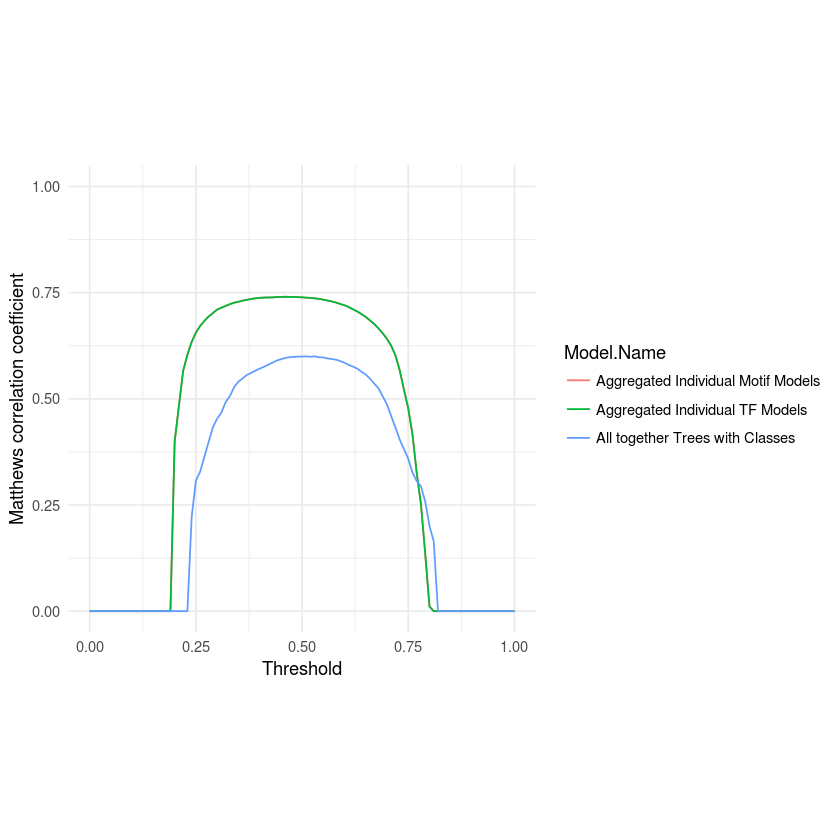

In [61]:
plot.mattcc.curve(compare_methods_df)

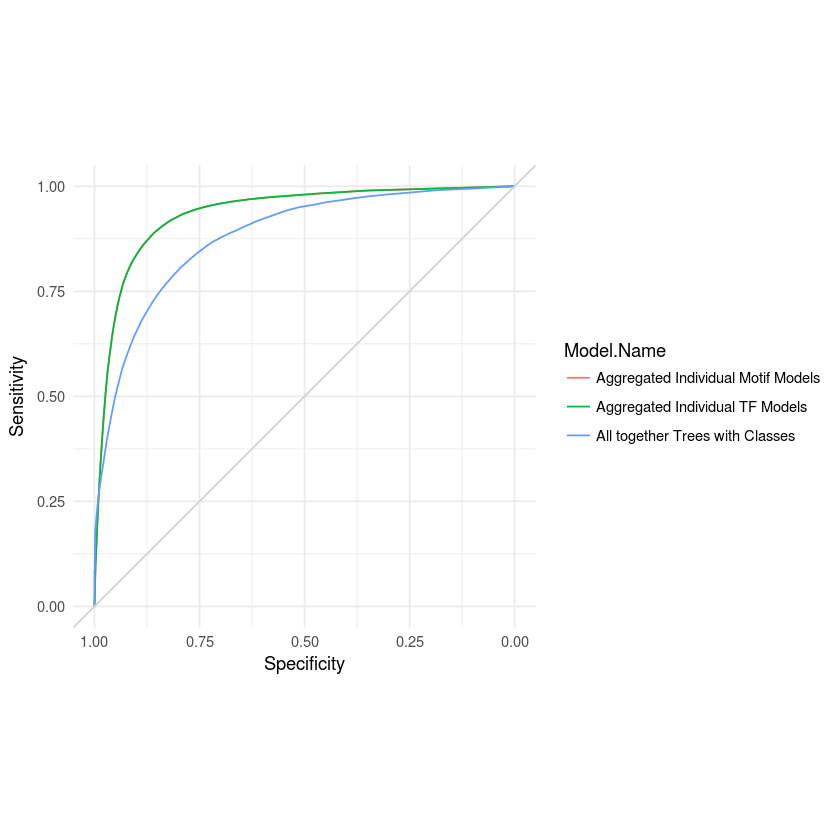

In [62]:
plot.roc.curve(compare_methods_df)

Warning message:
“Removed 69 rows containing missing values (geom_path).”

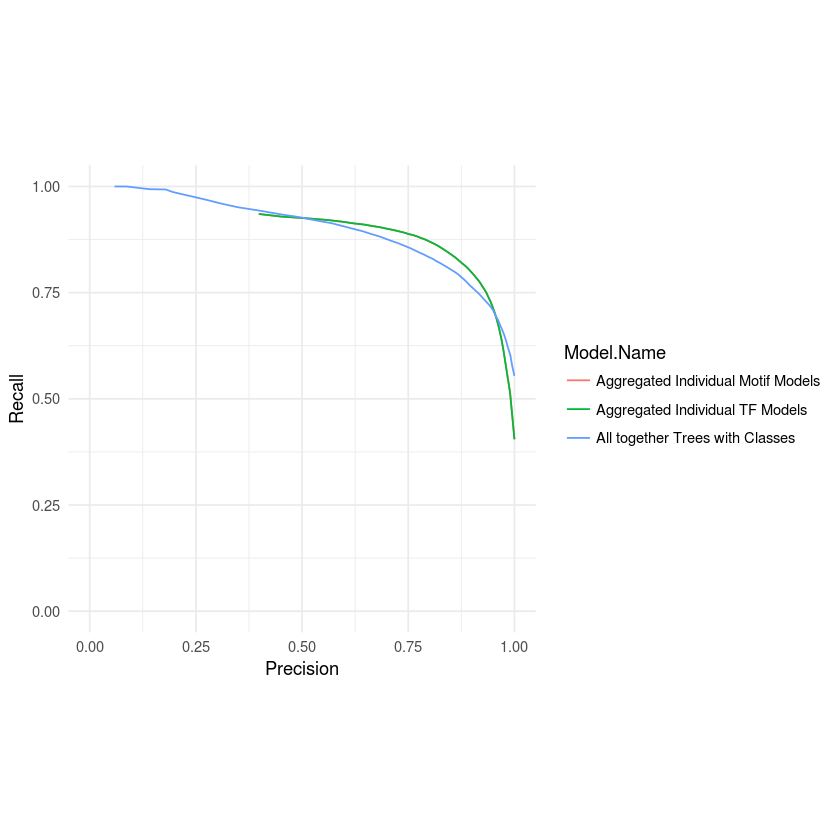

In [63]:
plot.precrecall.curve(compare_methods_df)